In [1]:
import json
from schema import (
    MaterialBase,
    MaterialLayer,
    Construction,
    ConstructionSet,
    Zone,
    Template,
    Library,
    UmiBase,
)
import networkx as nx
import matplotlib.pyplot as plt

# Schema


Defining all objects with Pydantic classes and Field constructors let's us trivially construct a JSON Schema. This schema can be saved to file, passed around, etc. It can be used with `datamodel-codegen` to succesfully rebuild the Pydantic classes, however you would lose any rich functions that go along with the objects, e.g. a function which computes an assemblies R-Value.


In [2]:
schema = Library.model_json_schema(mode="serialization")

with open("schema.json", "w") as f:
    json.dump(schema, f, indent=4)

print(json.dumps(schema, indent=4))

{
    "$defs": {
        "Construction": {
            "description": "A Construction is a set of Material Layers that represent an assembly.",
            "properties": {
                "id": {
                    "format": "uuid4",
                    "title": "Object ID",
                    "type": "string"
                },
                "Layers": {
                    "allOf": [
                        {
                            "$ref": "#/$defs/UmiList_MaterialLayer_"
                        }
                    ],
                    "description": "The list of Material Layers which define this construction",
                    "title": "Material Layers"
                }
            },
            "required": [
                "id",
                "Layers"
            ],
            "title": "Construction",
            "type": "object"
        },
        "ConstructionSet": {
            "description": "A Zone Construction Set defines the assemblies for the walls, roo

# Test


We can define a library at will similarly to before. Here, we define a few `Material` objects as well as a `MaterialLayer` which uses one of the materials.


In [3]:
generic_mat_a = MaterialBase(Conductivity=1, SpecificHeat=800, Density=200)

generic_mat_b = MaterialBase(Conductivity=2, SpecificHeat=1000, Density=300)

shared_face = MaterialLayer(
    Thickness=0.1,
    Material=generic_mat_a,
)

shared_face.Material.Conductivity = 2

# Demonstrate that nested objects work as expected
assert generic_mat_a.Conductivity == 2
print(generic_mat_a.DiffusionCoefficient)

1.25e-05


We can also take a look at the graph structure, and how it changes after swapping the material association.


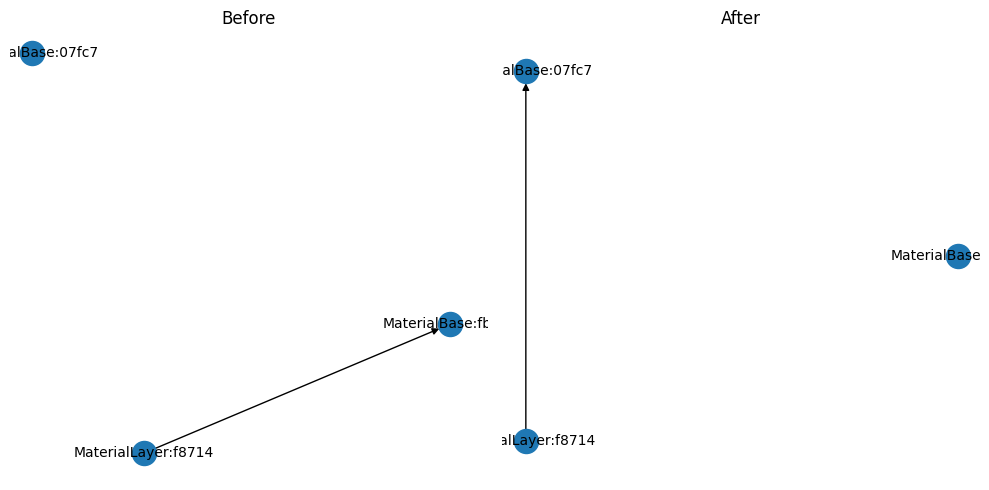

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Before")
ax[1].set_title("After")

before_layout = nx.kamada_kawai_layout(UmiBase.graph, scale=0.25)
nx.draw(
    UmiBase.graph,
    pos=before_layout,
    ax=ax[0],
    labels={g: f"{g.__class__.__name__}:{str(g.id)[:5]}" for g in UmiBase.graph},
    font_size=10,
)

shared_face.Material = generic_mat_b
after_layout = nx.kamada_kawai_layout(UmiBase.graph)

nx.draw(
    UmiBase.graph,
    pos=after_layout,
    ax=ax[1],
    labels={g: f"{g.__class__.__name__}:{str(g.id)[:5]}" for g in UmiBase.graph},
    font_size=10,
)
fig.tight_layout()

Next, we can make a `Construction` which makes use of the shared face, as well as defines a new `MaterialLayer` inline using the other `Material`.


In [5]:
from schema import UmiList

wall = Construction(
    Layers=UmiList[MaterialLayer](
        objects=[
            shared_face,
            MaterialLayer(Thickness=0.05, Material=generic_mat_b),
            shared_face,
        ]
    )
)

# Demontsrate that the shared face is really shared
assert wall.Layers[0] is wall.Layers[2]

Once again, we can look at how the graph changes when we swap the material assignment.


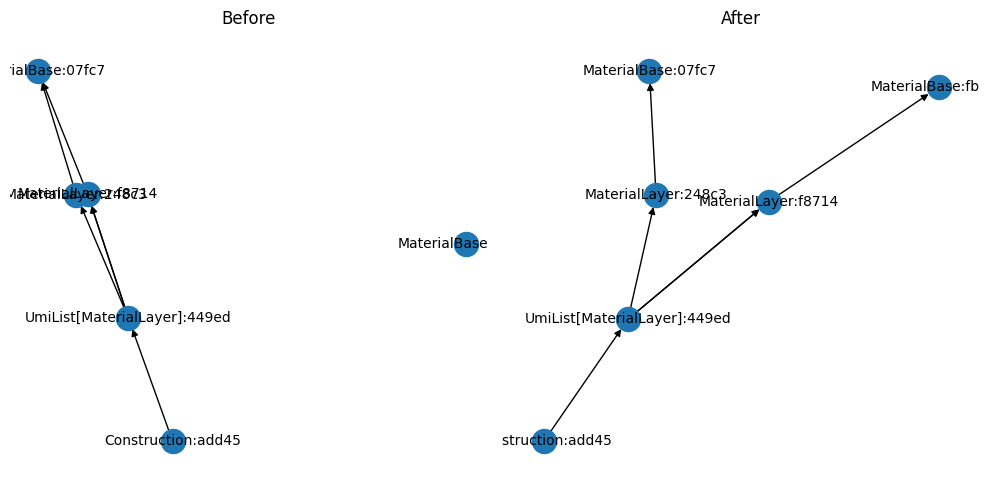

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Before")
ax[1].set_title("After")
before_layout = nx.kamada_kawai_layout(UmiBase.graph)
nx.draw(
    UmiBase.graph,
    pos=before_layout,
    ax=ax[0],
    labels={g: f"{g.__class__.__name__}:{str(g.id)[:5]}" for g in UmiBase.graph},
    font_size=10,
)

shared_face.Material = generic_mat_a
after_layout = nx.kamada_kawai_layout(UmiBase.graph)

nx.draw(
    UmiBase.graph,
    pos=after_layout,
    ax=ax[1],
    labels={g: f"{g.__class__.__name__}:{str(g.id)[:5]}" for g in UmiBase.graph},
    font_size=10,
)
fig.tight_layout()

Now let's define a `Zone`, using our existing `wall` for most of the `Construction` objects within the `ConstructionSet` (defined inline), and a separate inline definition for the `Construction` used for the `Slab`. This new `Construction` will use a mix of existing `MaterialLayer` objects, new layers with existing materials, and new layers with new materials.


In [7]:
perim = Zone(
    DaylightWorkplaneHeight=1,
    Constructions=ConstructionSet(
        Partition=wall,
        Roof=wall,
        Ground=wall,
        Wall=wall,
        Slab=Construction(
            Layers=UmiList[MaterialLayer](
                objects=[
                    shared_face,
                    shared_face,
                    shared_face,
                    MaterialLayer(
                        Thickness=0.5,
                        Material=generic_mat_b,
                    ),
                    MaterialLayer(
                        Thickness=0.5,
                        Material=MaterialBase(
                            Conductivity=0.35, SpecificHeat=500, Density=100
                        ),
                    ),
                ]
            )
        ),
    ),
)

Now let's make a copy of the zone for the core.


In [8]:
core = perim.model_copy()

core.DaylightWorkplaneHeight = perim.DaylightWorkplaneHeight + 1

# demonstrate that ids change when copying
assert core.id != perim.id

# Demonstrate that top level fields are decoupled
assert core.DaylightWorkplaneHeight != perim.DaylightWorkplaneHeight

# Demonstrate the nested fields are still shared
assert core.Constructions is perim.Constructions

Finally, let's make our `Library`.


In [9]:
lib = Library(
    Templates=UmiList[Template](
        objects=[
            Template(
                Perimeter=perim,
                Core=core,
                YearFrom=2000,
                YearTo=2001,
                Country="USA",
            )
        ]
    )
)

# Serializing


Saving a library is as easy as dumping it.


In [10]:
data = lib.model_dump_json(indent=4)

with open("lib.json", "w") as f:
    f.write(data)

print(data)

{
    "id": "3ef5bb84-3560-486a-acce-b355bc9c3622",
    "Templates": {
        "id": "8fbbbeaf-d387-4b4f-af78-8fb49f1c503f",
        "objects": [
            {
                "id": "4196e08f-04ac-4a16-a58b-6230e77d186b",
                "Perimeter": {
                    "id": "121669e2-66bb-4e63-9e85-8c8cc99243ba",
                    "DaylightWorkplaneHeight": 1.0,
                    "Constructions": {
                        "id": "06110cb5-f1bb-42b7-a701-4350d64861f7",
                        "Partition": {
                            "id": "add450dc-bc74-4588-b675-dfac0ca09c18",
                            "Layers": {
                                "id": "449ed66c-feb9-4d9f-935f-be0702f9e776",
                                "objects": [
                                    {
                                        "id": "f8714f5d-13f5-4fe2-a676-923adb574547",
                                        "Thickness": 0.1,
                                        "Material": {
        

Notice that this is shown as a deeply nested object, however all objects have `id`s. Normally, if we tried to deserialize this object using Pydantic, we would lose all shared referencing...

However, there is a neat/simple trick in the validation logic when objects are craeted which fetches an existing version of the object from a cache if the id is already represented in the cache.

We can see that cache:


In [11]:
list(UmiBase.all.values())

[MaterialBase(id=UUID('fb054d56-0068-4ef7-b044-efbec065aa6d'), Conductivity=2.0, SpecificHeat=800.0, Density=200.0, DiffusionCoefficient=1.25e-05),
 MaterialBase(id=UUID('07fc7fb2-56eb-4379-be76-12adb4be3d7e'), Conductivity=2.0, SpecificHeat=1000.0, Density=300.0, DiffusionCoefficient=6.666666666666667e-06),
 MaterialLayer(id=UUID('f8714f5d-13f5-4fe2-a676-923adb574547'), Thickness=0.1, Material=MaterialBase(id=UUID('fb054d56-0068-4ef7-b044-efbec065aa6d'), Conductivity=2.0, SpecificHeat=800.0, Density=200.0, DiffusionCoefficient=1.25e-05)),
 MaterialLayer(id=UUID('248c3ebc-2c96-490d-9d04-7c2650b64050'), Thickness=0.05, Material=MaterialBase(id=UUID('07fc7fb2-56eb-4379-be76-12adb4be3d7e'), Conductivity=2.0, SpecificHeat=1000.0, Density=300.0, DiffusionCoefficient=6.666666666666667e-06)),
 UmiList[MaterialLayer](id=UUID('449ed66c-feb9-4d9f-935f-be0702f9e776'), objects=[MaterialLayer(id=UUID('f8714f5d-13f5-4fe2-a676-923adb574547'), Thickness=0.1, Material=MaterialBase(id=UUID('fb054d56-006

However, we can also serialize our data as a flat list of objects by type, equivalent to how they would be stored in a relational database.


In [12]:
flat_serialization = UmiBase.flat_serialization(as_json=True)

with open(f"flatlib.json", "w") as f:
    f.write(flat_serialization)

print(flat_serialization)

{
    "MaterialBase": [
        {
            "id": "fb054d56-0068-4ef7-b044-efbec065aa6d",
            "Conductivity": 2.0,
            "SpecificHeat": 800.0,
            "Density": 200.0,
            "DiffusionCoefficient": 1.25e-05
        },
        {
            "id": "07fc7fb2-56eb-4379-be76-12adb4be3d7e",
            "Conductivity": 2.0,
            "SpecificHeat": 1000.0,
            "Density": 300.0,
            "DiffusionCoefficient": 6.666666666666667e-06
        },
        {
            "id": "200d7018-72e9-4d14-a386-0bb6cabfecda",
            "Conductivity": 0.35,
            "SpecificHeat": 500.0,
            "Density": 100.0,
            "DiffusionCoefficient": 7e-06
        }
    ],
    "MaterialLayer": [
        {
            "id": "f8714f5d-13f5-4fe2-a676-923adb574547",
            "Thickness": 0.1,
            "Material": {
                "id": "fb054d56-0068-4ef7-b044-efbec065aa6d"
            }
        },
        {
            "id": "248c3ebc-2c96-490d-9d04-7c2650

Reconstructing from the flat, effectively tabular data is a little trickier to do automatically without resorting to a database.


# Graph


We can also now look at the complete graph layout.


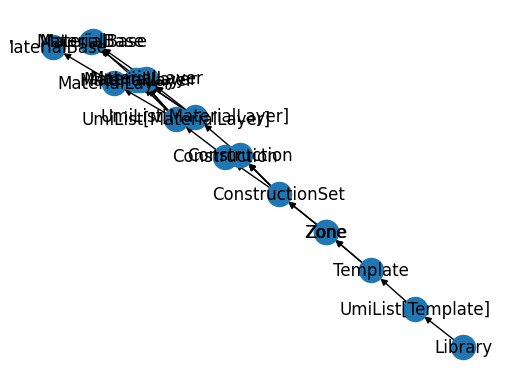

In [13]:
plt.figure()
nx.draw_kamada_kawai(
    UmiBase.graph, ax=plt.gca(), labels={g: g.__class__.__name__ for g in UmiBase.graph}
)